In [52]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [53]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [54]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [55]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [56]:
# reflect an existing database into a new model
# reflect the tables

Base = automap_base()
Base.prepare(engine, reflect=True)


/var/folders/df/9zhgj0g13nq7fh103b71dyw40000gn/T/ipykernel_10948/173709357.py:5: SADeprecationWarning: The AutomapBase.prepare.reflect parameter is deprecated and will be removed in a future release.  Reflection is enabled when AutomapBase.prepare.autoload_with is passed.
  Base.prepare(engine, reflect=True)


In [57]:
# View all of the classes that automap found
for class_name in Base.classes.keys():
    print(class_name)

measurement
station


In [58]:
# Save references to the classes named 'station' and 'measurement'
Station = Base.classes.station
Measurement = Base.classes.measurement

In [59]:
# Create a session to interact with the database
session = Session(engine)

In [60]:
# Query the first station and measurement entries
first_station = session.query(Station).first()
first_measurement = session.query(Measurement).first()

# Print out the first station and measurement to verify
print("First Station:", first_station.__dict__)
print("First Measurement:", first_measurement.__dict__)

First Station: {'_sa_instance_state': <sqlalchemy.orm.state.InstanceState object at 0x307306ff0>, 'longitude': -157.8168, 'station': 'USC00519397', 'id': 1, 'name': 'WAIKIKI 717.2, HI US', 'latitude': 21.2716, 'elevation': 3.0}
First Measurement: {'_sa_instance_state': <sqlalchemy.orm.state.InstanceState object at 0x30705d490>, 'prcp': 0.08, 'station': 'USC00519397', 'tobs': 65.0, 'id': 1, 'date': '2010-01-01'}


# Exploratory Precipitation Analysis

In [61]:

# Query the most recent date in the Measurement table
most_recent_date = session.query(func.max(Measurement.date)).scalar()

# Print the most recent date
print("Most Recent Date:", most_recent_date)

Most Recent Date: 2017-08-23


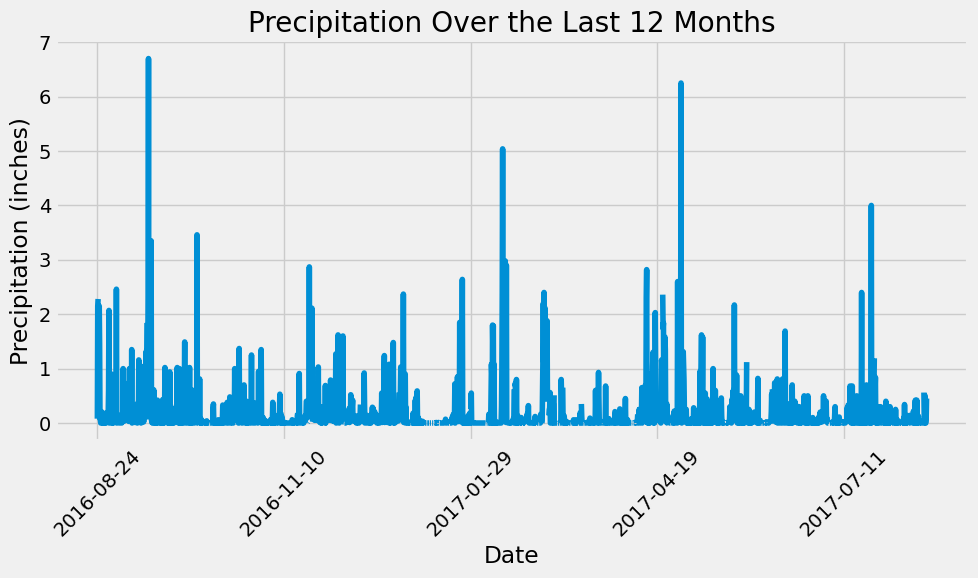

In [62]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
# Calculate the date one year from the last date in data set.

most_recent_date = dt.datetime.strptime(most_recent_date, '%Y-%m-%d')
one_year_ago = most_recent_date - dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores

precipitation_data = (
    session.query(Measurement.date, Measurement.prcp)
    .filter(Measurement.date >= one_year_ago)
    .order_by(Measurement.date)
    .all()
)

# Save the query results as a Pandas DataFrame. Explicitly set the column names

precipitation_df = pd.DataFrame(precipitation_data, columns=['Date', 'Precipitation'])

# Sort the dataframe by date

precipitation_df_sorted = precipitation_df

# Use Pandas Plotting with Matplotlib to plot the data

precipitation_df_sorted.plot(x='Date', y='Precipitation', figsize=(10, 6), legend=False)
plt.title('Precipitation Over the Last 12 Months')
plt.xlabel('Date')
plt.ylabel('Precipitation (inches)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [63]:
# Use Pandas to calculate the summary statistics for the precipitation data
# Calculate the summary statistics for the precipitation data
precipitation_summary = precipitation_df_sorted['Precipitation'].describe()

# Display the summary statistics
precipitation_summary


count    2015.000000
mean        0.176462
std         0.460288
min         0.000000
25%         0.000000
50%         0.020000
75%         0.130000
max         6.700000
Name: Precipitation, dtype: float64

# Exploratory Station Analysis

In [64]:
# Design a query to calculate the total number of stations in the dataset
total_stations = session.query(func.count(Station.station)).scalar()

# Print the result
print(f"Total number of stations: {total_stations}")

Total number of stations: 9


In [65]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order
# query to find the most active stations
active_stations = (
    session.query(Measurement.station, func.count(Measurement.station))
    .group_by(Measurement.station)
    .order_by(func.count(Measurement.station).desc())
    .all()
)
# Print the results
print("Most active stations:")
for station, count in active_stations:
    print(f"Station: {station}, Number of Observations: {count}")


Most active stations:
Station: USC00519281, Number of Observations: 2772
Station: USC00519397, Number of Observations: 2724
Station: USC00513117, Number of Observations: 2709
Station: USC00519523, Number of Observations: 2669
Station: USC00516128, Number of Observations: 2612
Station: USC00514830, Number of Observations: 2202
Station: USC00511918, Number of Observations: 1979
Station: USC00517948, Number of Observations: 1372
Station: USC00518838, Number of Observations: 511


In [66]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.

# Identify the most active station ID
most_active_station = active_stations[0][0]  

# Write the query to calculate the lowest, highest, and average temperature
temperature_stats = (
    session.query(
        func.min(Measurement.tobs),
        func.max(Measurement.tobs),
        func.avg(Measurement.tobs)
    )
    .filter(Measurement.station == most_active_station)
    .all()
)
# extract and print 
min_temp, max_temp, avg_temp = temperature_stats[0]

print(f"Temperature statistics for the most active station (ID: {most_active_station}):")
print(f"Lowest Temperature: {min_temp}°F")
print(f"Highest Temperature: {max_temp}°F")
print(f"Average Temperature: {avg_temp:.2f}°F")

Temperature statistics for the most active station (ID: USC00519281):
Lowest Temperature: 54.0°F
Highest Temperature: 85.0°F
Average Temperature: 71.66°F


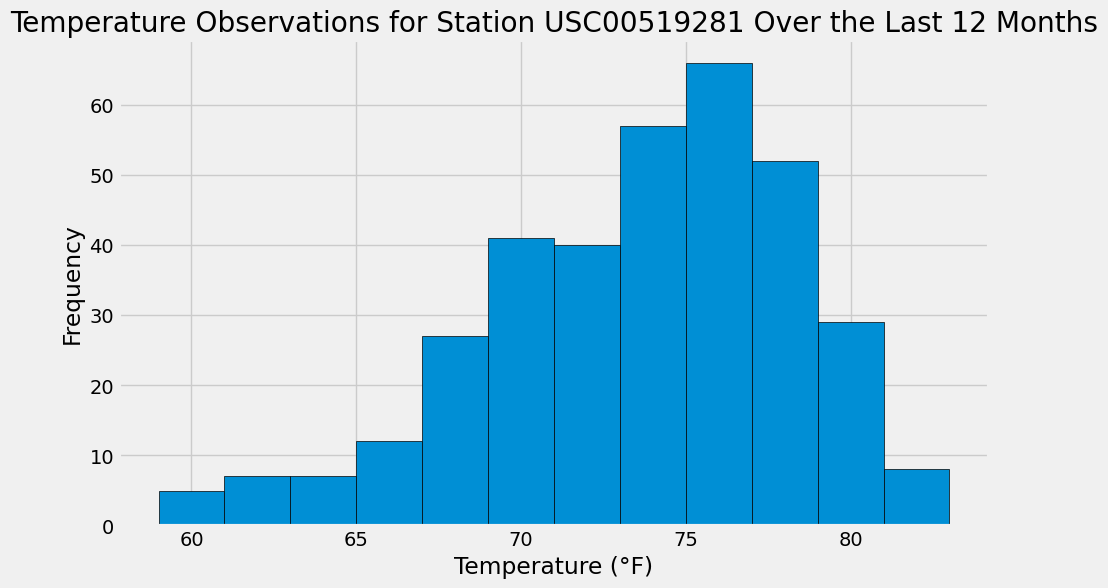

In [67]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

# Identify the most active station ID
most_active_station = active_stations[0][0] 

# Calculate the date one year before the most recent date
most_recent_date = session.query(func.max(Measurement.date)).scalar()
most_recent_date = dt.datetime.strptime(most_recent_date, '%Y-%m-%d')
one_year_ago = most_recent_date - dt.timedelta(days=365)

# Query the last 12 months of temperature observation data for the most active station
temperature_data = (
    session.query(Measurement.tobs)
    .filter(Measurement.station == most_active_station)
    .filter(Measurement.date >= one_year_ago)
    .all()
)

# Convert the query results to a list of temperatures
temperatures = [temp[0] for temp in temperature_data]

# Step 4: Plot the results as a histogram
plt.figure(figsize=(10, 6))
plt.hist(temperatures, bins=12, edgecolor='black')
plt.title(f'Temperature Observations for Station {most_active_station} Over the Last 12 Months')
plt.xlabel('Temperature (°F)')
plt.ylabel('Frequency')
plt.show()




# Close Session

In [68]:
# Close Session
session.close()